<a href="https://www.kaggle.com/code/tridibraj/brain-tumer-detection-cnn-model-94?scriptVersionId=206081104" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
import pandas as pd
from torchviz import make_dot
from IPython.display import Image
from torchinfo import summary
import torch
import torch.nn as nn



In [63]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom Dataset class for loading brain tumor data

In [65]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create dataset instances

In [66]:
train_dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=train_transform)
test_dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=test_transform)

In [67]:
# # Function to count images per class
# def count_images_per_class(dataset):
#     class_counts = {}
    
#     for _, label in dataset:
#         if label in class_counts:
#             class_counts[label] += 1
#         else:
#             class_counts[label] = 1
            
#     return class_counts

# # Count images in train and test datasets
# train_class_counts = count_images_per_class(train_dataset)
# test_class_counts = count_images_per_class(test_dataset)

# # Convert to DataFrame for better visualization
# train_class_counts_df = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count'])
# test_class_counts_df = pd.DataFrame(list(test_class_counts.items()), columns=['Class', 'Count'])

# print("Training Class Counts:")
# print(train_class_counts_df)

# print("\nTesting Class Counts:")
# print(test_class_counts_df)


# Create dataloaders & define the CNN model

In [68]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 classes
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

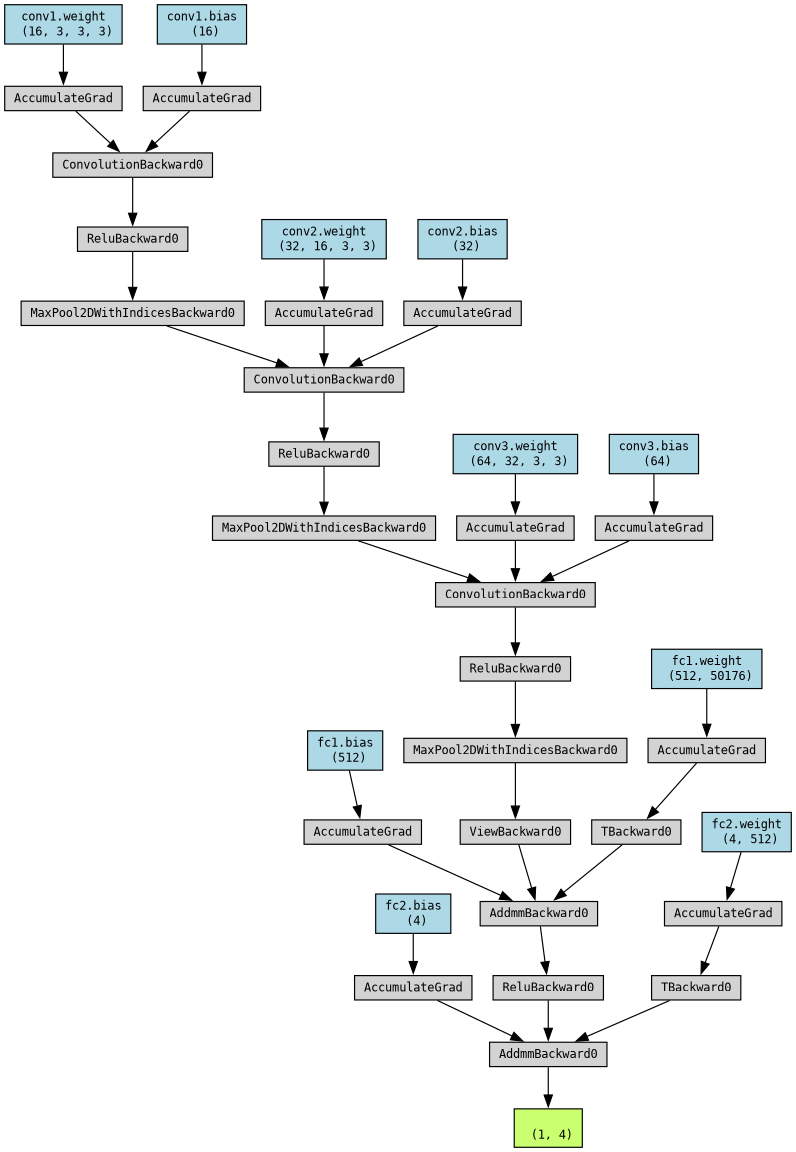

In [69]:
# from torchviz import make_dot
# from IPython.display import Image

model = CNNModel()
x = torch.randn(1, 3, 224, 224)  # Dummy input
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_model')
Image('cnn_model.png')

In [70]:
# from torchinfo import summary
# import torch
# import torch.nn as nn
model = CNNModel()
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CNNModel                                 [1, 3, 224, 224]          [1, 4]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 16, 224, 224]         448                       [3, 3]                    22,478,848
├─MaxPool2d: 1-2                         [1, 16, 224, 224]         [1, 16, 112, 112]         --                        2                         --
├─Conv2d: 1-3                            [1, 16, 112, 112]         [1, 32, 112, 112]         4,640                     [3, 3]                    58,204,160
├─MaxPool2d: 1-4                         [1, 32, 112, 112]         [1, 32, 56, 56]           --                        2                         --
├─Conv2d: 1-5                            [1, 32, 56, 56]           [1, 64, 56, 56]       

# Initialize model, criterion, and optimizer

In [71]:
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Model save location


In [72]:
save_path = '/kaggle/working/trained_model.pth'

# Ensure the directory exists before saving
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Model Training & Performance evaluation

In [73]:
from PIL import Image

In [74]:
def compute_loss_and_accuracy(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [75]:
def train_model(model, criterion, optimizer, num_epochs=5, save_path='trained_model.pth'):
    model.train()
    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = correct / total
        
        # Testing phase
        test_loss, test_accuracy = compute_loss_and_accuracy(model, test_loader, criterion)
        
        # Save the model if it has the best accuracy
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), save_path)

        # Append losses and accuracies for plotting
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Print results for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    print(f"Training complete. Best accuracy: {best_accuracy:.4f}. Model saved to {save_path}")
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [76]:
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, criterion, optimizer, num_epochs=5, save_path=save_path)

Epoch [1/5], Train Loss: 0.7103, Train Accuracy: 0.7166, Test Loss: 0.4927, Test Accuracy: 0.7902
Epoch [2/5], Train Loss: 0.3707, Train Accuracy: 0.8571, Test Loss: 0.3407, Test Accuracy: 0.8642
Epoch [3/5], Train Loss: 0.2321, Train Accuracy: 0.9102, Test Loss: 0.2500, Test Accuracy: 0.9047
Epoch [4/5], Train Loss: 0.1600, Train Accuracy: 0.9410, Test Loss: 0.1684, Test Accuracy: 0.9390
Epoch [5/5], Train Loss: 0.1040, Train Accuracy: 0.9617, Test Loss: 0.1443, Test Accuracy: 0.9542
Training complete. Best accuracy: 0.9617. Model saved to /kaggle/working/trained_model.pth


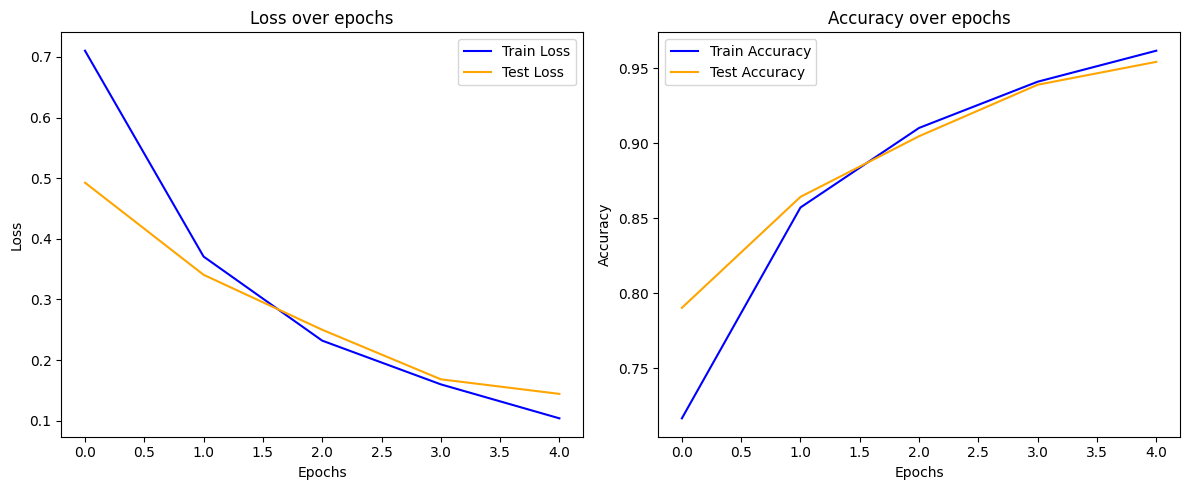

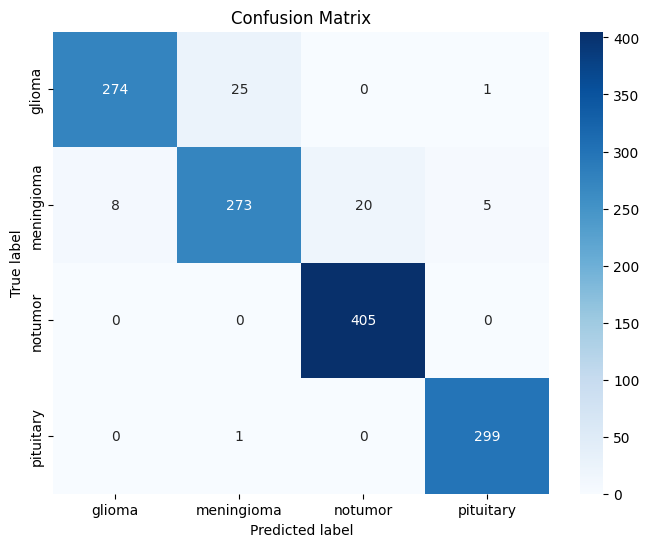

Class: glioma
Precision: 0.9716
Recall: 0.9133
F1 Score: 0.9416

Class: meningioma
Precision: 0.9130
Recall: 0.8922
F1 Score: 0.9025

Class: notumor
Precision: 0.9529
Recall: 1.0000
F1 Score: 0.9759

Class: pituitary
Precision: 0.9803
Recall: 0.9967
F1 Score: 0.9884

Class: macro avg
Precision: 0.9545
Recall: 0.9505
F1 Score: 0.9521

Class: weighted avg
Precision: 0.9542
Recall: 0.9542
F1 Score: 0.9538



In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def compute_additional_metrics(all_labels, all_predictions):
    # Generate a classification report which includes precision, recall, F1 score for each class
    report = classification_report(all_labels, all_predictions, target_names=train_dataset.classes, output_dict=True)
    return report

def plot_training_testing_graphs(train_losses, train_accuracies, test_losses, test_accuracies, save_path=None):
    # Plotting Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='orange')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(test_accuracies, label='Test Accuracy', color='orange')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path)
    plt.show()

def generate_confusion_matrix(model, save_path=None):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')

    # Save the confusion matrix if save_path is provided
    if save_path:
        plt.savefig(save_path)
    plt.show()

    return all_labels, all_predictions

# Generate reports and save graphs
plot_training_testing_graphs(train_losses, train_accuracies, test_losses, test_accuracies, save_path='training_testing_graphs.png')

# Generate confusion matrix and compute metrics, saving the confusion matrix
all_labels, all_predictions = generate_confusion_matrix(model, save_path='confusion_matrix.png')
report = compute_additional_metrics(all_labels, all_predictions)

# Print precision, recall, F1 score for each class
for class_name, metrics in report.items():
    if isinstance(metrics, dict):  # Check if it's a class
        print(f"Class: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1-score']:.4f}")
        print()  # Blank line for readability


# Test the model

In [78]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
import random

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for the testing dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom Dataset class for loading brain tumor data
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path  # Returning img_path to track image name

# Load the model state dictionary
model_path = '/kaggle/working/trained_model.pth'
state_dict = torch.load(model_path, map_location=device)


# Instantiate and load the model
model = CNNModel().to(device)
model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode

# Create dataset instance for testing
test_dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=test_transform)

# Randomly select 10 images from the test set
random_indices = np.random.choice(len(test_dataset), 10, replace=False)

print("Image Name              | Actual Label | Predicted Label")
print("----------------------------------------------------------")

# Perform inference on each selected image
for idx in random_indices:
    image, label, img_path = test_dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    
    # Get the actual and predicted labels as strings
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[predicted.item()]
    img_name = os.path.basename(img_path)
    
    # Print out the image name, actual label, and predicted label
    print(f"{img_name:22} | {actual_label:12} | {predicted_label}")


Image Name              | Actual Label | Predicted Label
----------------------------------------------------------
Te-no_0365.jpg         | notumor      | notumor
Te-gl_0255.jpg         | glioma       | glioma
Te-pi_0198.jpg         | pituitary    | pituitary
Te-me_0271.jpg         | meningioma   | meningioma
Te-no_0214.jpg         | notumor      | notumor
Te-pi_0060.jpg         | pituitary    | pituitary
Te-meTr_0004.jpg       | meningioma   | meningioma
Te-no_0115.jpg         | notumor      | notumor
Te-gl_0140.jpg         | glioma       | glioma
Te-no_0252.jpg         | notumor      | notumor


# k-Fold Cross Validation

In [82]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms

# Define your CNN model (replace with your actual model architecture)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Example architecture; replace with your actual architecture
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust input size based on your image size
        self.fc2 = nn.Linear(128, 4)  # 4 classes: glioma, meningioma, notumor, pituitary

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # Output logits for the classes

# Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Set the paths for your datasets
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
model_save_path = '/kaggle/working/trained_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset
train_dataset = BrainTumorDataset(root_dir=train_data_dir, transform=train_transform)

# K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store results
fold_results = []

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, save_path):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights

            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Save the trained model
    torch.save(model.state_dict(), save_path)

# Function to test the model
def test_model(model, criterion, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')
    return accuracy

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))): 
    print(f"Fold {fold + 1}/{k_folds}")

    # Create data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)

    # Initialize model, criterion, and optimizer
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, save_path=model_save_path)
    
    # After training, evaluate the model and store results
    fold_accuracy = test_model(model, criterion, val_loader)  # This should return accuracy
    fold_results.append(fold_accuracy)

# Average results across folds
average_accuracy = np.mean(fold_results)
print(f"Average accuracy across {k_folds} folds: {average_accuracy:.4f}")


Fold 1/5
Epoch [1/5], Loss: 0.7510
Epoch [2/5], Loss: 0.4282
Epoch [3/5], Loss: 0.2813
Epoch [4/5], Loss: 0.1993
Epoch [5/5], Loss: 0.1449
Validation Accuracy: 0.9405
Fold 2/5
Epoch [1/5], Loss: 0.8090
Epoch [2/5], Loss: 0.4398
Epoch [3/5], Loss: 0.3228
Epoch [4/5], Loss: 0.2237
Epoch [5/5], Loss: 0.1659
Validation Accuracy: 0.9108
Fold 3/5
Epoch [1/5], Loss: 0.7341
Epoch [2/5], Loss: 0.3978
Epoch [3/5], Loss: 0.2721
Epoch [4/5], Loss: 0.1794
Epoch [5/5], Loss: 0.1304
Validation Accuracy: 0.9098
Fold 4/5
Epoch [1/5], Loss: 0.6730
Epoch [2/5], Loss: 0.3695
Epoch [3/5], Loss: 0.2564
Epoch [4/5], Loss: 0.1741
Epoch [5/5], Loss: 0.1197
Validation Accuracy: 0.9291
Fold 5/5
Epoch [1/5], Loss: 0.6610
Epoch [2/5], Loss: 0.3370
Epoch [3/5], Loss: 0.2170
Epoch [4/5], Loss: 0.1521
Epoch [5/5], Loss: 0.1046
Validation Accuracy: 0.9229
Average accuracy across 5 folds: 0.9226


In [80]:
# import os

# # Specify the file path
# file_path = '/kaggle/working/trained_model.pth'

# # Check if the file exists and delete it
# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"Deleted the file: {file_path}")
# else:
#     print(f"File not found: {file_path}")


In [81]:
# import os
# import shutil

# # Define the output directory path
# output_dir = '/kaggle/working/'

# # Check if the output directory exists
# if os.path.exists(output_dir):
#     # Iterate over all files and directories in the output directory
#     for filename in os.listdir(output_dir):
#         file_path = os.path.join(output_dir, filename)
#         try:
#             # Remove files or directories
#             if os.path.isfile(file_path) or os.path.islink(file_path):
#                 os.unlink(file_path)  # Remove file or link
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)  # Remove directory and its contents
#         except Exception as e:
#             print(f'Failed to delete {file_path}. Reason: {e}')
# else:
#     print(f'The directory {output_dir} does not exist.')
